In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import gc
import matplotlib.image as mpimg
import seaborn as sns
# Keras 
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img 
from keras.preprocessing import image
from tqdm import tqdm

In [2]:
path_to_folder_eli = "/Users/tomashegewisch/Downloads/data_set/train_elephants"
image_paths = os.listdir(path_to_folder_eli)
train_eliphants = [path_to_folder_eli+"/"+i for i in image_paths]

path_to_folder_zebra = "/Users/tomashegewisch/Downloads/data_set/train_zebras"
image_paths = os.listdir(path_to_folder_zebra)
train_zebras = [path_to_folder_zebra+"/"+i for i in image_paths]

In [3]:
train_imgs = train_zebras[:400] + train_eliphants[:400]
#train_imgs = train_zebras + train_eliphants
random.shuffle(train_imgs)

del train_eliphants
del train_zebras
gc.collect()

44

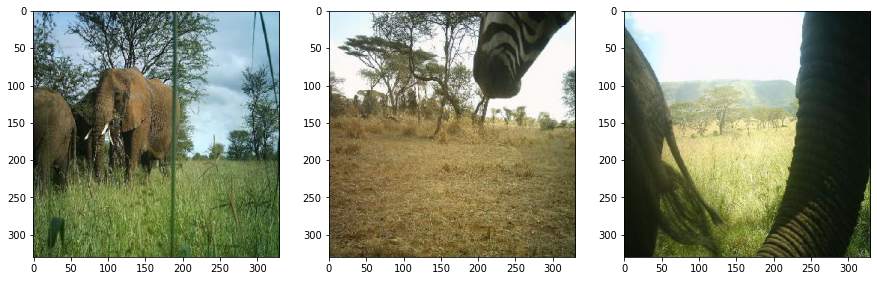

In [4]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,ima in enumerate(train_imgs[0:3]):
    img = mpimg.imread(ima)
    imgplot = ax[i].imshow(img)
plt.show() 

In [5]:
#We can change this later, if we want
nrows = 150
ncolums = 150 
channels = 3

In [6]:
def read_and_process_image(list_of_images):
    x = []
    y = []
    for image in tqdm(list_of_images):
        try:
            x.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR) , (nrows, ncolums) , interpolation = cv2.INTER_CUBIC))
        except:
            print("An image caused a probelem",image)
            continue
        if "train_elephants" in image:
            y.append(0)
        else:
            y.append(1)   
    return x,y 

In [7]:
X, y = read_and_process_image(train_imgs)
del train_imgs
gc.collect()

100%|██████████| 800/800 [00:03<00:00, 240.10it/s]


42

/Users/tomashegewisch/lunch_lab_project_final/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


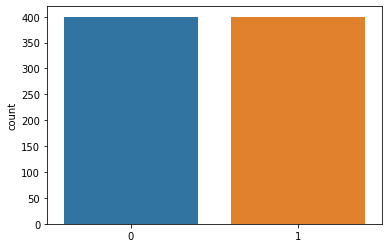

In [8]:
X = np.array(X)
y = np.array(y)
sns.countplot(y)
plt.show()

In [9]:
print("The shape of x:", X.shape)
print("The shape of y:", y.shape)
# X -> batch size, height, width and channels 

The shape of x: (800, 150, 150, 3)
The shape of y: (800,)


In [10]:
#"The model takes as input an array of ( height, width,channels)"

In [11]:
# split the data into train and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.20, random_state = 123)

In [12]:
print("The shape of X_train:",X_train.shape)
print("The Shape of X_val:", X_val.shape)
print("The shape of y_train:",y_train.shape)
print("The shape of y_val:", y_val.shape)

The shape of X_train: (640, 150, 150, 3)
The Shape of X_val: (160, 150, 150, 3)
The shape of y_train: (640,)
The shape of y_val: (160,)


In [13]:
#clear
del X
del y
gc.collect()

2515

In [14]:
ntrain = len(X_train)
nval = len(X_val)

In [15]:
batch_size = 32 

# Convolutional Neural Network (convnet)

In [16]:
#Network architecture is just the way we arrange our convolution layers

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape =(150, 150, 3)))
model.add(layers.MaxPooling2D ((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation = "relu"))
model.add(layers.MaxPooling2D ((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = "relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = "relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # Dropot of regularisation
model.add(layers.Dense(512, activation = "relu"))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [19]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-14), metrics = ['acc'])

In [20]:
# train_datagen = ImageDataGenerator(
#       rescale=1./255,
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest')
# val_datatgen = ImageDataGenerator(1./255)

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_generator =  train_datagen.flow(X_train, y_train, batch_size = batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size= batch_size)
# train_datagen.fit(X_train)

In [23]:
history = model.fit(train_generator, steps_per_epoch = ntrain // batch_size, 
    epochs = 10, 
    validation_data = val_generator, 
    validation_steps = nval//batch_size)

Epoch 1/10
20/20 [==============================] - 39s 2s/step - loss: 0.6923 - acc: 0.5268 - val_loss: 0.6940 - val_acc: 0.4375
Epoch 2/10
20/20 [==============================] - 38s 2s/step - loss: 0.6936 - acc: 0.5017 - val_loss: 0.6940 - val_acc: 0.4375
Epoch 3/10
20/20 [==============================] - 42s 2s/step - loss: 0.6928 - acc: 0.5246 - val_loss: 0.6940 - val_acc: 0.4375
Epoch 4/10
20/20 [==============================] - 34s 2s/step - loss: 0.6938 - acc: 0.5041 - val_loss: 0.6940 - val_acc: 0.4375
Epoch 5/10
20/20 [==============================] - 44s 2s/step - loss: 0.6942 - acc: 0.4954 - val_loss: 0.6940 - val_acc: 0.4375
Epoch 6/10
20/20 [==============================] - 35s 2s/step - loss: 0.6933 - acc: 0.4934 - val_loss: 0.6940 - val_acc: 0.4375
Epoch 7/10
20/20 [==============================] - 35s 2s/step - loss: 0.6927 - acc: 0.5129 - val_loss: 0.6940 - val_acc: 0.4375
Epoch 8/10
20/20 [==============================] - 38s 2s/step - loss: 0.6908 - acc: 0.55

Maybe increasing the number of epochs and playing with some hyperparameters like batch size and the optimizer will help improve this score.


In [24]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

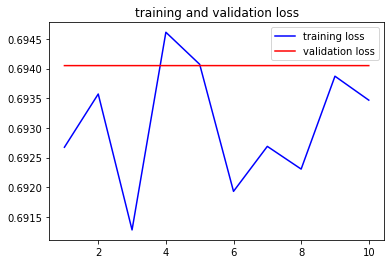

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range (1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss , 'b', label = 'training loss')
plt.plot(epochs, val_loss, 'r', label = 'validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

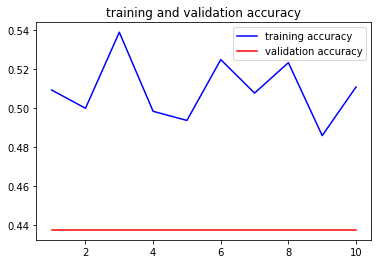

In [26]:
plt.figure()
plt.plot(epochs, acc , 'b', label = 'training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'validation accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

In [27]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_val, y_val, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 2s 394ms/step - loss: 2.4828 - acc: 0.4375
test loss, test acc: [2.4828474521636963, 0.4375]


0.9017309


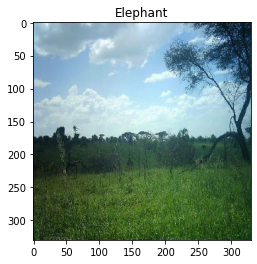

In [28]:
path_to_folder = '/Users/tomashegewisch/Downloads/data_set/test/'
image_paths = os.listdir(path_to_folder)
file = np.random.choice(image_paths)
path_to_test_image = path_to_folder + file
test_image = image.load_img(path_to_test_image, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result[0][0])
if result[0][0] > 0.5:
    prediction = 'Elephant'
else:
    prediction = 'Zebra'

img = mpimg.imread(path_to_test_image)
imgplot = plt.imshow(img)
plt.title(prediction)
plt.show()